In [1]:
import pandas as pd
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.util import summary
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler      
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor

In [2]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

def create_samples(n, df):
    index = df.index
    rows_list = []
    for i in range(n):
        idx = np.random.choice(index)
        row = df.loc[idx].copy()
        row['IRI Increase'] += np.random.uniform(0.01, 0.05)
        rows_list.append(row)
    
    return rows_list

## Data Preprocessing

In [2]:
df = pd.read_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/IRI/IRI_netherlands_v2.xlsx')
df.head()

,ID lane segment,IRI,Date measurement,Regional service,Road,lane,From,To,Segment length,Segment width,Construction date,Surface layer type,Age,Original version number,BPS3
0,55212,1.40,2021-06-13,ON,1HRR,2R-R,113.8,113.9,100,3.5,2020-08-01,ZOAB,0,22,ON_28_1HRR_2R-R_113.8_113.9_2020
1,4560,1.09,2016-03-17,NN,1HRL,2R-L,171.0,171.1,100,3.5,2011-05-01,ZOAB+,4,17,NN_28_1HRL_2R-L_171.0_171.1_2011
2,22330,0.94,2016-04-08,ON,1HRL,2R-L,38.8,38.9,100,3.5,2009-12-30,ZOAB,6,17,ON_28_1HRL_2R-L_38.8_38.9_2009
3,24345,1.06,2017-01-23,ON,1HRR,2R-R,41.9,42.0,101,3.5,2009-12-30,ZOAB+,7,20,ON_28_1HRR_2R-R_41.9_42.0_2009
4,144127,1.32,2016-12-06,ZN,1HRR,2R-R,193.2,193.3,100,3.5,2006-07-19,ZOAB,10,20,ZN_2_1HRR_2R-R_193.2_193.3_2006


In [3]:
# change type to measurement year column
df['Date measurement'] = pd.to_datetime(df['Date measurement'], format='%Y%m%d')


# change type to construction year column
df['Construction date'] = pd.to_datetime(df['Construction date'], format='%Y%m%d')

# create years until next measurement column
df['Years Until Next Measurement'] = np.nan

# create IRI Increase column
df['IRI Increase'] = np.nan

# create Segment ID column
df['Segment ID'] = df['BPS3'].apply(lambda x: x.split('_')[1])

# create Side column
df['Side'] = df['Road'].apply(lambda x: x[-1])

df.rename(columns={'Regional service':'Region', 'lane':'Lane'}, inplace=True)

# select useful columns
df = df[['BPS3', 'Segment ID', 'Construction date', 'Date measurement', 'Age', 'Years Until Next Measurement', 'Region',
                            'Road', 'Surface layer type', 'Side', 'Lane', 'Segment length', 'Segment width', 'From', 'To', 'IRI', 'IRI Increase']]

# sort each key of BPS3 by Measurement Year
df.sort_values(by=['BPS3', 'Age'], inplace=True)

In [4]:
df.head()

,BPS3,Segment ID,Construction date,Date measurement,Age,Years Until Next Measurement,Region,Road,Surface layer type,Side,Lane,Segment length,Segment width,From,To,IRI,IRI Increase
35848,MN_12_1HRL_2R-L_57.2_57.3_2005,12,2005-07-01,2014-12-16,9,NaN,MN,1HRL,ZOAB,L,2R-L,100,3.5,57.2,57.3,1.10,NaN
53801,MN_12_1HRL_2R-L_57.2_57.3_2005,12,2005-07-01,2016-02-17,10,NaN,MN,1HRL,ZOAB,L,2R-L,100,3.5,57.2,57.3,1.04,NaN
48292,MN_12_1HRL_2R-L_57.2_57.3_2005,12,2005-07-01,2016-10-31,11,NaN,MN,1HRL,ZOAB,L,2R-L,100,3.5,57.2,57.3,1.30,NaN
89396,MN_12_1HRL_2R-L_57.2_57.3_2018,12,2018-07-01,2019-04-19,0,NaN,MN,1HRL,ZOAB+,L,2R-L,100,3.5,57.2,57.3,1.20,NaN
35866,MN_12_1HRL_2R-L_57.2_57.3_2018,12,2018-07-01,2020-04-02,1,NaN,MN,1HRL,ZOAB+,L,2R-L,100,3.5,57.2,57.3,1.40,NaN


Next, we will preprocess the data to make it suitable for training the model. We will perform the following steps:
 - Compute Years Until Next Measurement for each row
 - Compute IRI increase rate for each row

In [5]:
def increase_index(key):
    df.loc[(df['BPS3'] == key),'Years Until Next Measurement'] = (df.loc[(df['BPS3'] == key),'Date measurement'].diff().shift(-1)/np.timedelta64(1, 'Y')).apply(lambda x: round(x, 2))[0:-1]
    df.loc[(df['BPS3'] == key),'IRI Increase'] = df.loc[(df['BPS3'] == key),'IRI'].diff().shift(-1)[0:-1] / df.loc[(df['BPS3'] == key),'Years Until Next Measurement'][0:-1]

In [ ]:
for key in df['BPS3'].unique():
    increase_index(key)

In [ ]:
# change type to years until next measurement column to float

df['Years Until Next Measurement'] = df['Years Until Next Measurement'].astype(float)

# select values from years until next measurement column between 0.8 and 1.2

df = df[(df['Years Until Next Measurement'] >= 0.8) & (df['Years Until Next Measurement'] <= 1.2)]

# drop rows with NaN values

df.dropna(inplace=True)

In [ ]:
# export to excel

df.to_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/IRI/IRI_netherlands_v4.xlsx', index=False)

# Joining the data

## Joining with INWEVA

In [2]:
iri_df = pd.read_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/IRI/IRI_netherlands_v4.xlsx')
traffic_df = pd.read_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/TreatedData/INWEVA_treated.xlsx')

In [3]:
iri_df[['Segment ID']] = iri_df[['Segment ID']].astype(int)
iri_df['From'] = iri_df['From'].astype(float)
iri_df['Side'] = iri_df['Side'].astype(str)

traffic_df[['Wegnr_van', 'Year']] = traffic_df[['Wegnr_van', 'Year']].astype(int)
traffic_df['From'] = traffic_df['From'].astype(float)
traffic_df['Ri_van'] = traffic_df['Ri_van'].astype(str)

traffic_df = traffic_df.sort_values(by=['From', 'Year', 'Wegnr_van', 'Ri_van'])

In [4]:
# obatain rows with iri increase greater than 0
iri_df = iri_df[iri_df['IRI Increase'] >= 0]

In [5]:
def merge_overlapping_ranges(iri_df, traffic_df):
    # The merge will be done by 3 columns: Segment ID, Side and Measurement Year in iri_df and Wegnr_van, Ri_van and Year in traffic_df
    cart_product = pd.merge(iri_df, traffic_df, how='left', left_on=['Segment ID', 'Side'], right_on=['Wegnr_van', 'Ri_van'])

    # Filtering overlapping ranges
    overlapping = (
        (cart_product['From_x'] <= cart_product['To_y']) &
        (cart_product['To_x'] >= cart_product['From_y'])
    )

    # Selecting overlapping rows and creating the merged DataFrame
    merged_df = cart_product[overlapping].assign(
        From=lambda x: np.maximum(x['From_x'], x['From_y']),
        To=lambda x: np.minimum(x['To_x'], x['To_y'])
    ).drop(columns=['From_x', 'From_y', 'To_x', 'To_y'])

    return merged_df

In [6]:
merged_data = merge_overlapping_ranges(iri_df, traffic_df)

# rename Year column

merged_data.rename(columns={'Year':'INWEVA Year'}, inplace=True)

# drow rows with the same values in From and To columns

merged_data = merged_data[merged_data['From'] != merged_data['To']]

# remove duplicates of the BPS3, INWEVA Year, Side, From and To columns

merged_data.drop_duplicates(subset=['BPS3', 'INWEVA Year', 'Side', 'From', 'To'], inplace=True)

In [7]:
merged_data = merged_data[['BPS3', 'Segment ID', 'Construction date', 'Date measurement', 'Age', 'Years Until Next Measurement', 'Region',
                            'Road', 'Surface layer type', 'Side', 'Lane', 'Segment length', 'Segment width', 'From', 'To', 'IRI', 'IRI Increase',
                             'INWEVA Year', 'etmaal_AL', 'etmaal_L1', 'etmaal_L2', 'etmaal_L3']].copy()

In [8]:
lista = []

# if a = day of the year/365, N = measurement year , perform this formula (1-a)*row(N) + a*row(N+1)
for key in merged_data['BPS3'].unique():
    for date in merged_data.loc[(merged_data['BPS3'] == key),'Date measurement'].unique():
        date = pd.to_datetime(date)
        a = date.dayofyear/365
        row_n = merged_data.loc[(merged_data['BPS3'] == key) & (merged_data['INWEVA Year'] == date.year), ['etmaal_AL', 'etmaal_L1', 'etmaal_L2', 'etmaal_L3']]
        row_n_plus_1 = merged_data.loc[(merged_data['BPS3'] == key) & (merged_data['INWEVA Year'] == date.year + 1), ['etmaal_AL', 'etmaal_L1', 'etmaal_L2', 'etmaal_L3']]
        if row_n.empty and a >= 0.8 and not row_n_plus_1.empty:
            final_row  = merged_data.loc[(merged_data['BPS3'] == key) & (merged_data['INWEVA Year'] == date.year + 1)].iloc[0]
            lista.append(final_row.to_dict())

        elif not row_n.empty and a <= 0.2 and row_n_plus_1.empty:
            final_row = merged_data.loc[(merged_data['BPS3'] == key) & (merged_data['INWEVA Year'] == date.year)].iloc[0]
            lista.append(final_row.to_dict())
            
        elif not row_n.empty and not row_n_plus_1.empty:
            replacement = (1-a)*row_n.values + a*row_n_plus_1.values
            # modify the values of etmaal from merged data with replacement
            final_row = merged_data.loc[(merged_data['BPS3'] == key) & (merged_data['Date measurement'] == date)].iloc[0].copy()
            final_row[['etmaal_AL', 'etmaal_L1', 'etmaal_L2', 'etmaal_L3']] = replacement[0]
            lista.append(final_row.to_dict())
        else:
            continue

In [9]:
# create a pandas dataframe from the list of dictionaries
final_df = pd.DataFrame(lista)
final_df  

,BPS3,Segment ID,Construction date,Date measurement,Age,Years Until Next Measurement,Region,Road,Surface layer type,Side,...,Segment width,From,To,IRI,IRI Increase,INWEVA Year,etmaal_AL,etmaal_L1,etmaal_L2,etmaal_L3
0,MN_12_1HRR_2R-R_63.6_63.7_2012,12,2012-09-09,2014-12-16,2,1.17,MN,1HRR,ZOAB+,R,...,3.5,63.6,63.7,0.70,0.145299,2015,29900.000000,27159.000000,1385.000000,1356.000000
1,MN_12_1HRR_3R-R_57.4_57.5_2019,12,2019-04-01,2020-04-02,1,1.06,MN,1HRR,ZOAB+,R,...,3.5,57.4,57.5,1.80,0.000000,2015,38409.589041,36507.342466,731.400000,1170.101370
2,MN_12_1HRR_3R-R_57.9_58.0_2012,12,2012-08-01,2014-12-16,2,1.17,MN,1HRR,ZOAB,R,...,3.5,57.9,58.0,1.30,0.042735,2015,42400.000000,37779.000000,1921.000000,2700.000000
3,MN_12_1HRR_3R-R_58.1_58.2_2010,12,2010-09-01,2014-12-16,4,1.17,MN,1HRR,ZOAB,R,...,3.5,58.1,58.2,0.70,0.307692,2015,42400.000000,37779.000000,1921.000000,2700.000000
4,MN_12_1HRR_3R-R_58.4_58.5_2010,12,2010-09-01,2014-12-16,4,1.17,MN,1HRR,ZOAB,R,...,3.5,58.4,58.5,1.10,0.094017,2015,42400.000000,37779.000000,1921.000000,2700.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14051,ZN_79_1HRR_2R-R_9.5_9.6_1999,79,1999-11-26,2014-11-13,14,1.20,ZN,1HRR,DAB,R,...,3.5,9.5,9.6,2.00,0.125000,2015,12500.000000,11482.000000,688.000000,330.000000
14052,ZN_79_1HRR_2R-R_9.6_9.7_1999,79,1999-11-26,2014-11-13,14,1.20,ZN,1HRR,DAB,R,...,3.5,9.6,9.7,1.00,0.016667,2015,12500.000000,11482.000000,688.000000,330.000000
14053,ZN_79_1HRR_2R-R_9.7_9.8_1999,79,1999-11-26,2014-11-13,14,1.20,ZN,1HRR,DAB,R,...,3.5,9.7,9.8,1.00,0.041667,2015,12500.000000,11482.000000,688.000000,330.000000
14054,ZN_79_1HRR_2R-R_9.8_9.9_1999,79,1999-11-26,2014-11-13,14,1.20,ZN,1HRR,DAB,R,...,3.5,9.8,9.9,0.80,0.050000,2015,12500.000000,11482.000000,688.000000,330.000000


## Joining with KNMI

In [10]:
knmi_df = pd.read_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/TreatedData/KNMI_treated.xlsx')

In [11]:
# drop column INWEVA Year from final_df

final_df.drop(columns=['INWEVA Year'], inplace=True)

In [12]:
for i, row in final_df.iterrows():
    date = row['Date measurement']
    a = date.dayofyear/365
    # get the row of the knmi_df with the same year as the date
    row_n = knmi_df.loc[(knmi_df['Year'] == date.year) & (knmi_df['Region'] == row['Region'])].iloc[0][2:]
    row_n_plus_1 = knmi_df.loc[(knmi_df['Year'] == date.year + 1) & (knmi_df['Region'] == row['Region'])].iloc[0][2:]
    replacement = (1-a)*row_n.values + a*row_n_plus_1.values
    final_df.loc[i, knmi_df.columns[2:]] = replacement

In [13]:
# move IRI Increase column to the end of the dataframe

final_df = final_df[[c for c in final_df if c not in ['IRI Increase']] + ['IRI Increase']]
final_df

,BPS3,Segment ID,Construction date,Date measurement,Age,Years Until Next Measurement,Region,Road,Surface layer type,Side,...,RH,SQ,SP,UG,FRZ,FRZT,HOT,COLD,RHA,IRI Increase
0,MN_12_1HRR_2R-R_63.6_63.7_2012,12,2012-09-09,2014-12-16,2,1.17,MN,1HRR,ZOAB+,R,...,23.636724,50.374066,38.872959,80.995684,60.664384,37.404110,2.917808,38.363014,8660.212329,0.145299
1,MN_12_1HRR_3R-R_57.4_57.5_2019,12,2019-04-01,2020-04-02,1,1.06,MN,1HRR,ZOAB+,R,...,22.652040,52.921148,40.098535,78.954986,117.969863,31.684932,4.471233,33.723288,8326.389041,0.000000
2,MN_12_1HRR_3R-R_57.9_58.0_2012,12,2012-08-01,2014-12-16,2,1.17,MN,1HRR,ZOAB,R,...,23.636724,50.374066,38.872959,80.995684,60.664384,37.404110,2.917808,38.363014,8660.212329,0.042735
3,MN_12_1HRR_3R-R_58.1_58.2_2010,12,2010-09-01,2014-12-16,4,1.17,MN,1HRR,ZOAB,R,...,23.636724,50.374066,38.872959,80.995684,60.664384,37.404110,2.917808,38.363014,8660.212329,0.307692
4,MN_12_1HRR_3R-R_58.4_58.5_2010,12,2010-09-01,2014-12-16,4,1.17,MN,1HRR,ZOAB,R,...,23.636724,50.374066,38.872959,80.995684,60.664384,37.404110,2.917808,38.363014,8660.212329,0.094017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14051,ZN_79_1HRR_2R-R_9.5_9.6_1999,79,1999-11-26,2014-11-13,14,1.20,ZN,1HRR,DAB,R,...,19.832374,50.872782,39.900889,78.552191,53.667580,42.931507,6.052968,43.931507,7272.149772,0.125000
14052,ZN_79_1HRR_2R-R_9.6_9.7_1999,79,1999-11-26,2014-11-13,14,1.20,ZN,1HRR,DAB,R,...,19.832374,50.872782,39.900889,78.552191,53.667580,42.931507,6.052968,43.931507,7272.149772,0.016667
14053,ZN_79_1HRR_2R-R_9.7_9.8_1999,79,1999-11-26,2014-11-13,14,1.20,ZN,1HRR,DAB,R,...,19.832374,50.872782,39.900889,78.552191,53.667580,42.931507,6.052968,43.931507,7272.149772,0.041667
14054,ZN_79_1HRR_2R-R_9.8_9.9_1999,79,1999-11-26,2014-11-13,14,1.20,ZN,1HRR,DAB,R,...,19.832374,50.872782,39.900889,78.552191,53.667580,42.931507,6.052968,43.931507,7272.149772,0.050000


In [14]:
# export to excel

final_df.to_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/TreatedData/IRI_Completed_v3.xlsx', index=False)

# Data Preparation

In [3]:
# read the completed dataset

df = pd.read_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/TreatedData/IRI_Completed_v3.xlsx')

In [4]:

X = df[['Age', 'IRI','etmaal_AL', 'etmaal_L1', 'etmaal_L2', 'etmaal_L3', 'FG', 'TG', 'TN', 'TX', 'RH', 'SQ', 'SP', 'UG', 'FRZ', 'FRZT', 'HOT', 'COLD', 'RHA']].copy()
y = df['IRI Increase'].values.copy()

# create dummy variables from Region column and surface layer type and concatenate them to the dataframe
X = pd.concat([X, pd.get_dummies(df['Region'], prefix='Region')], axis=1)
X = pd.concat([X, pd.get_dummies(df['Surface layer type'], prefix='Surface')], axis=1)
X = pd.concat([X, pd.get_dummies(df['Side'], prefix='Side')], axis=1)
X = pd.concat([X, pd.get_dummies(df['Lane'], prefix='Lane')], axis=1)

# split the data into training and test sets and reset the index
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# scale the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

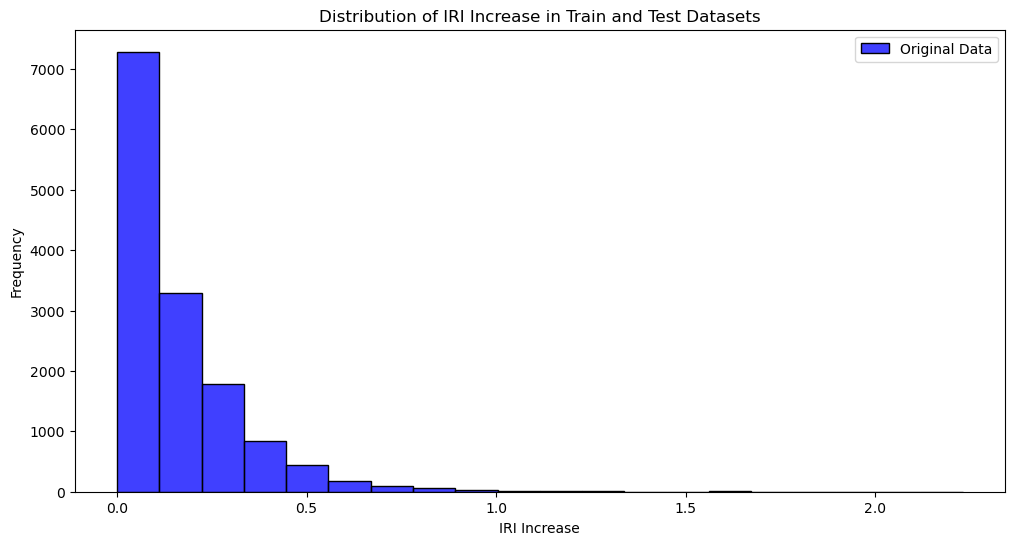

In [11]:
# plot the distribution of IRI Increase in the train and test datasets

plt.figure(figsize=(12, 6))
sns.histplot(y, bins=20, color='blue', label='Original Data')
plt.xlabel('IRI Increase')
plt.ylabel('Frequency')
plt.title('Distribution of IRI Increase in Train and Test Datasets')
plt.legend()
plt.show()

# Linear Model

First, we will train a linear model to predict the IRI increase rate. This model will include all the features available in the dataset.

MSE:  0.06869186590662393


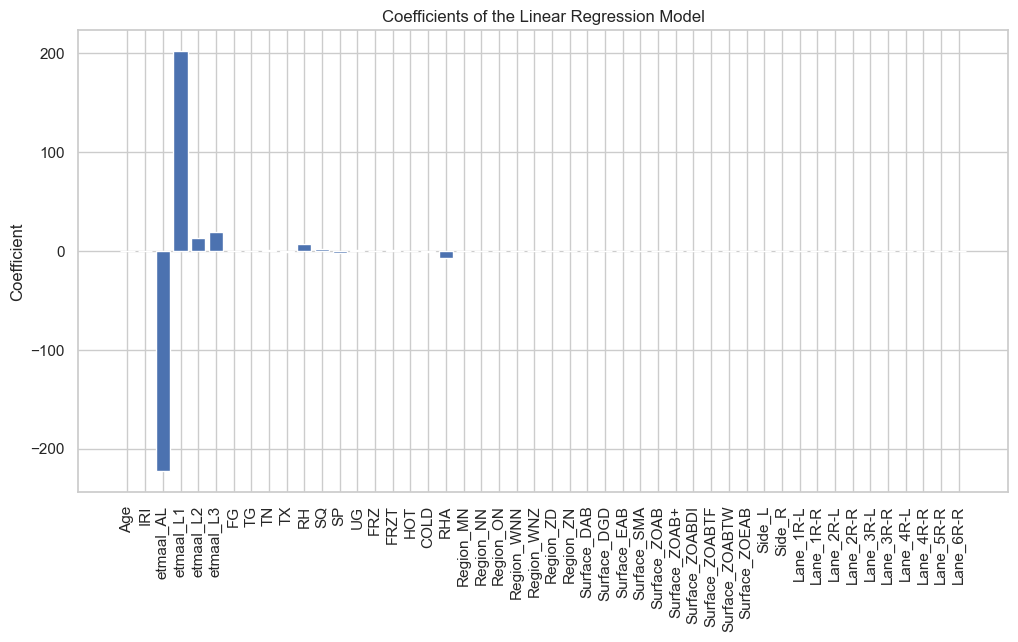

In [66]:
lr = LinearRegression()

y_train_aux = y_train[y_train >= 0.2]
y_test_aux = y_test[y_test >= 0.2]
X_train_aux = X_train_scaled[y_train >= 0.2].copy()
X_test_aux = X_test_scaled[y_test >= 0.2].copy()

lr.fit(X_train_aux, y_train_aux) 
y_pred_test_lr = lr.predict(X_test_scaled)
y_pred_train_lr = lr.predict(X_train_scaled)

print('MSE: ', mean_squared_error(y_test, y_pred_test_lr))

# create an graphic with the coefficients of the linear regression model
plt.figure(figsize=(12, 6))
plt.bar(X_train_scaled.columns, lr.coef_)
plt.xticks(rotation=90)
plt.ylabel('Coefficient')
plt.title('Coefficients of the Linear Regression Model')
plt.show()



## ANOVA

Anova will be used to select the most relevant features for the linear model.

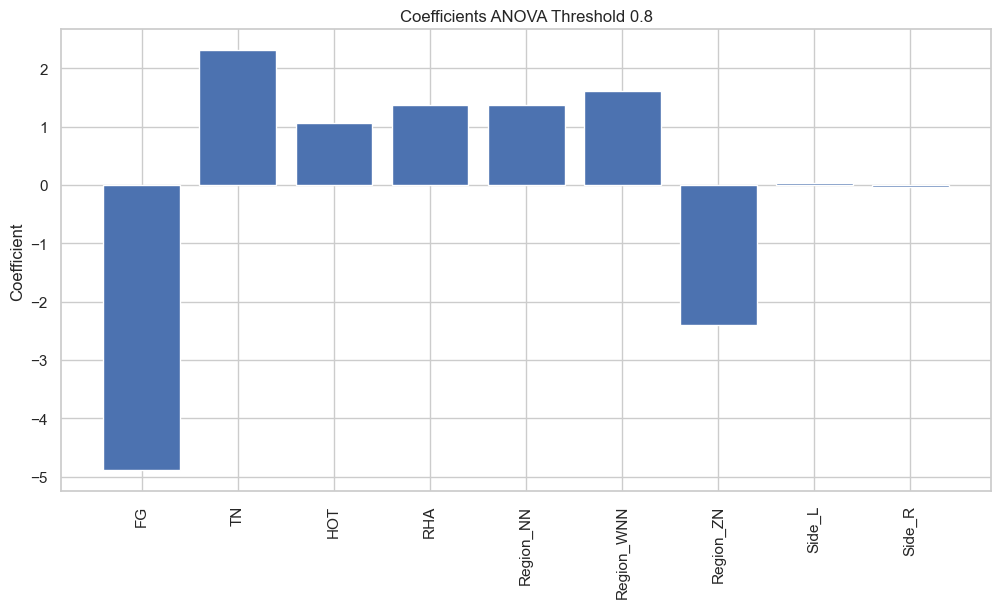

In [92]:
# perform ANOVA test to see if the model is statistically significant

import statsmodels.api as sm
from statsmodels.formula.api import ols

t = 0.8
y_train_aux = y_train[y_train >= t]
y_test_aux = y_test[y_test >= t]
X_train_anova = X_train_scaled[y_train >= t].copy()
X_test_anova = X_test_scaled[y_test >= t].copy()

model = sm.OLS(y_train_aux, X_train_anova).fit()

# Perform stepwise backward elimination

while len(model.pvalues) > 1 and model.pvalues.max() > 0.05:
    # Remove the variable with the highest p-value
    X_train_anova = X_train_anova.drop(model.pvalues.idxmax(), axis=1)
    # Fit the updated model
    model = sm.OLS(y_train_aux, X_train_anova).fit()

# plot the coefficients of the final model

plt.figure(figsize=(12, 6))
plt.bar(X_train_anova.columns, model.params)
plt.xticks(rotation=90)
plt.ylabel('Coefficient')
plt.title(f'Coefficients ANOVA Threshold {t}')
plt.show()



Anova Iteration

In [ ]:
lr = LinearRegression()
pca = PCA(n_components=0.95)
coefs = pd.DataFrame()

X_train_anova = X_train_scaled.copy()
X_test_anova = X_test_scaled.copy()
X_train_anova = sm.add_constant(X_train_anova)
X_test_anova = sm.add_constant(X_test_anova)

for i in frange(0.0, 1, 0.2):
    y_train_aux = y_train[y_train >= i]
    y_test_aux = y_test[y_test >= i]
    X_train_aux = X_train_anova[y_train >= i].copy()
    X_test_aux = X_test_anova[y_test >= i].copy()

    model = sm.OLS(y_train_aux, X_train_aux).fit()

    while len(model.pvalues) > 1 and model.pvalues.max() > 0.05:
        # Remove the variable with the highest p-value
        X_train_aux = X_train_aux.drop(model.pvalues.idxmax(), axis=1)
        # Fit the updated model
        model = sm.OLS(y_train_aux, X_train_aux).fit()
        
    lr.fit(X_train_aux, y_train_aux)
    y_test_lr = lr.predict(X_test_aux[X_train_aux.columns])
    y_train_lr = lr.predict(X_train_aux)

    # concatenate the coefficients of the linear regression model, including the intercept, with the coefs dataframe. This time, the coefficients are not always the same.
    coefs = pd.concat([coefs, pd.DataFrame(np.append(lr.intercept_, lr.coef_), index=['Intercept'] + X_train_aux.columns.tolist(), columns=[f'Umbral_{i}'])], axis=1)
    #--------------------------------------------------

    print(f'For IRI Increase greater than {i}:')
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].scatter(y_train_aux, y_train_lr, alpha=0.5, s=8, c='r')
    ax[0].set_xlabel("Observed Values")
    ax[0].set_ylabel("Predicted Values")
    ax[0].set_title("Train ANOVA Model")
    ax[0].set_xlim([0, 2])
    ax[0].set_ylim([-0.2, 2])
    train_corr = np.corrcoef(y_train_aux, y_train_lr)[0, 1]

    ax[1].scatter(y_test_aux, y_test_lr, alpha=0.5, s=8)
    ax[1].set_xlabel("Observed Values")
    ax[1].set_ylabel("Predicted Values")
    ax[1].set_title("Test Anova Model")
    ax[1].set_xlim([0, 2])
    ax[1].set_ylim([-0.2, 2])
    test_corr = np.corrcoef(y_test_aux, y_test_lr)[0, 1]

    plt.show()
    print(f'ANOVA Train Correlation: {train_corr}')
    print(f'ANOVA Test Correlation: {test_corr}')
    print('--------------------------------------------------', end='\n\n')


## PCA

MSE:  0.033086522771140284


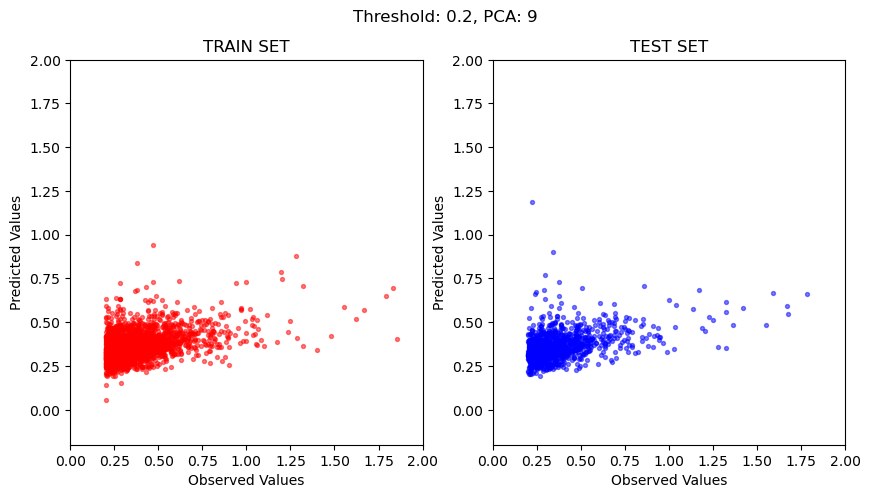

PCA Train Correlation: 0.42011607041774374
PCA Test Correlation: 0.4240273168589845
--------------------------------------------------



In [17]:
# perform PCA

i = 0.2
p = 9
pca = PCA(n_components=p)

y_train_aux = y_train[y_train >= i]
y_test_aux = y_test[y_test >= i]
X_train_pca = X_train_scaled[y_train >= i].copy()
X_test_pca = X_test_scaled[y_test >= i].copy()


# build a linear regression model to predict IRI Increase

lr = LinearRegression()
lr.fit(X_train_pca, y_train_aux)
y_test_lr = lr.predict(X_test_pca)
y_train_lr = lr.predict(X_train_pca)

print('MSE: ', mean_squared_error(y_test_aux, y_test_lr))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle(f'Threshold: {i}, PCA: {p}')

ax[0].scatter(y_train_aux, y_train_lr, alpha = 0.5, color='red', s = 8)
ax[0].set_xlim(0, 2)
ax[0].set_ylim(-0.2, 2)
ax[0].set_xlabel("Observed Values")
ax[0].set_ylabel("Predicted Values")
ax[0].set_title("TRAIN SET")
test_pca_corr = np.corrcoef(y_train_aux, y_train_lr)[0, 1]

ax[1].scatter(y_test_aux, y_test_lr, alpha = 0.5, color='blue', s = 8)
ax[1].set_xlim(0, 2)
ax[1].set_ylim(-0.2, 2)
ax[1].set_xlabel("Observed Values")
ax[1].set_ylabel("Predicted Values")
ax[1].set_title("TEST SET")
train_pca_corr = np.corrcoef(y_test_aux, y_test_lr)[0, 1]

plt.show()
print(f'PCA Train Correlation: {test_pca_corr}')
print(f'PCA Test Correlation: {train_pca_corr}')
print('--------------------------------------------------', end='\n\n')

PCA Components Plot

For IRI Increase greater than 0.0:
9839


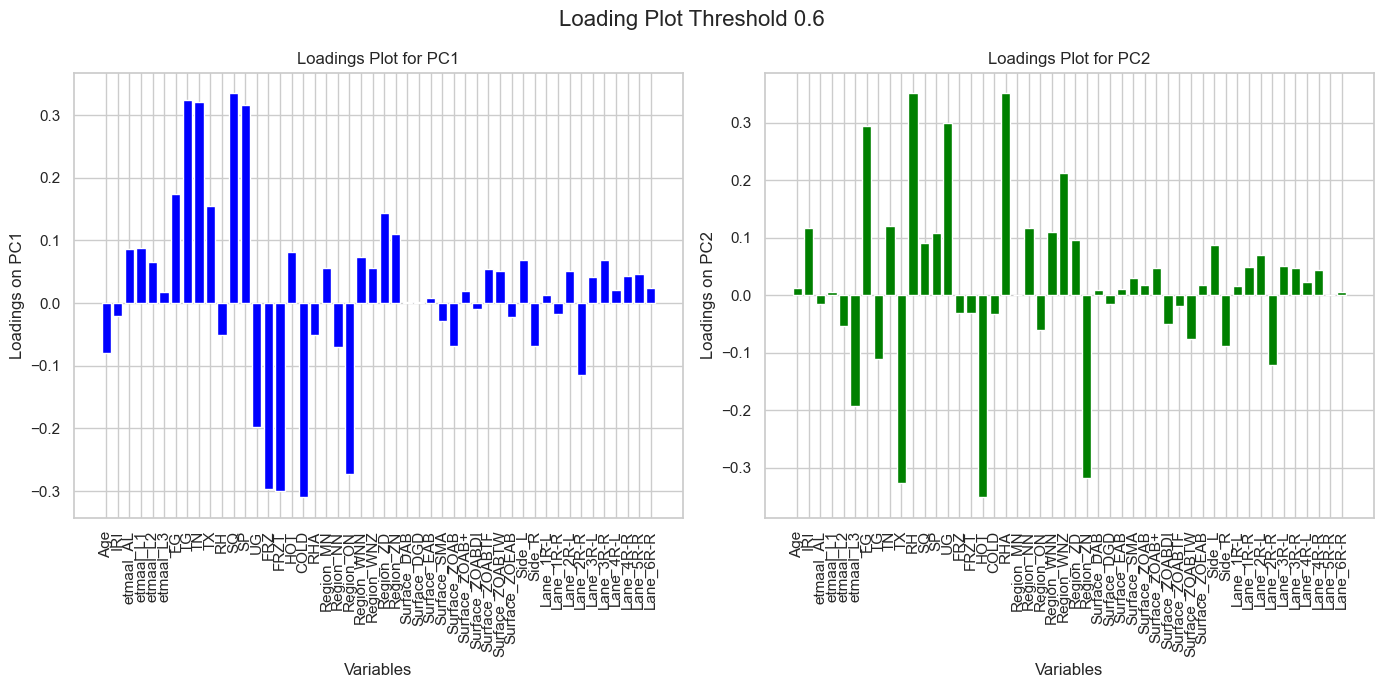

For IRI Increase greater than 0.2:
2830


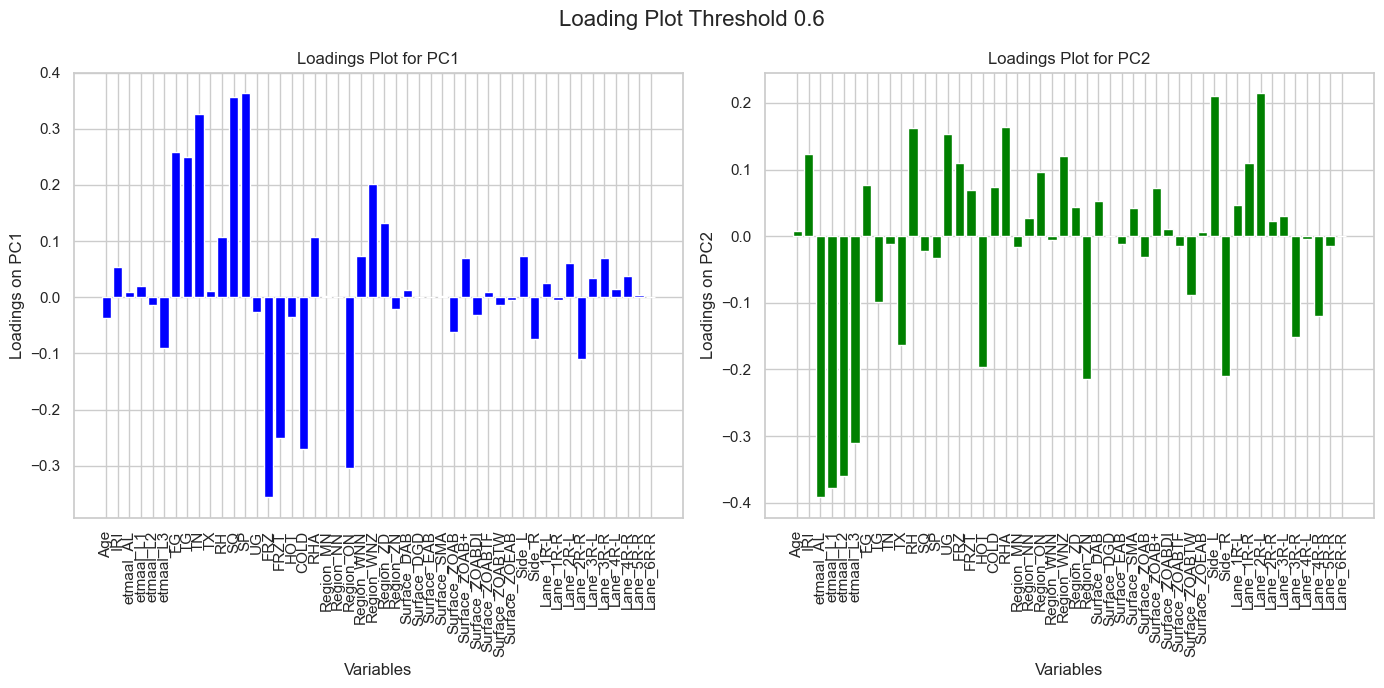

For IRI Increase greater than 0.4:
791


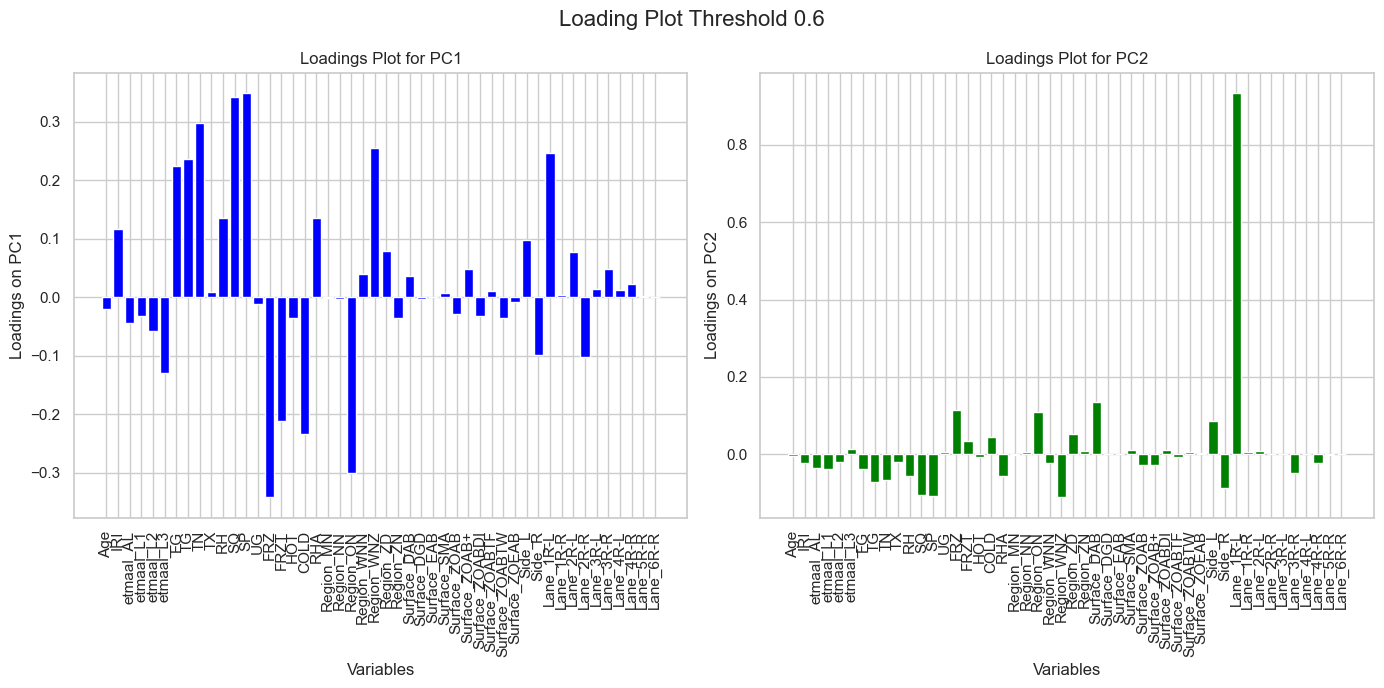

For IRI Increase greater than 0.6000000000000001:
220


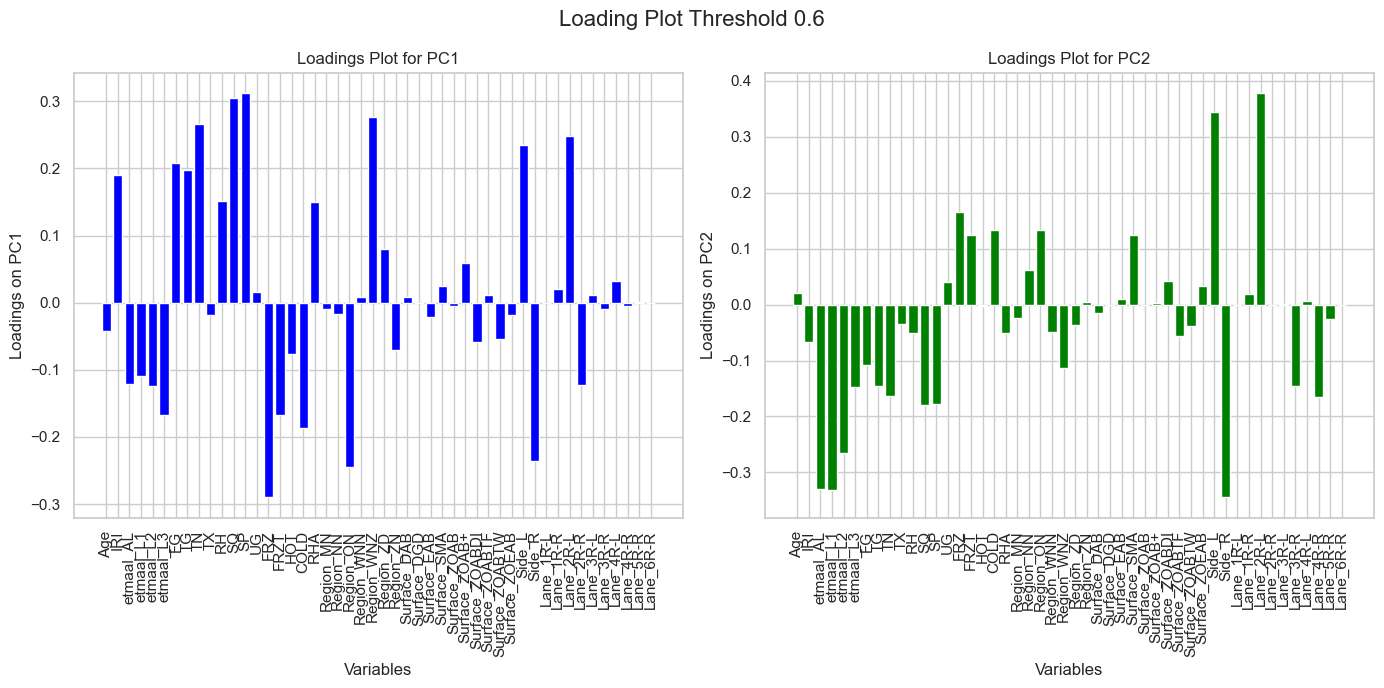

For IRI Increase greater than 0.8:
84


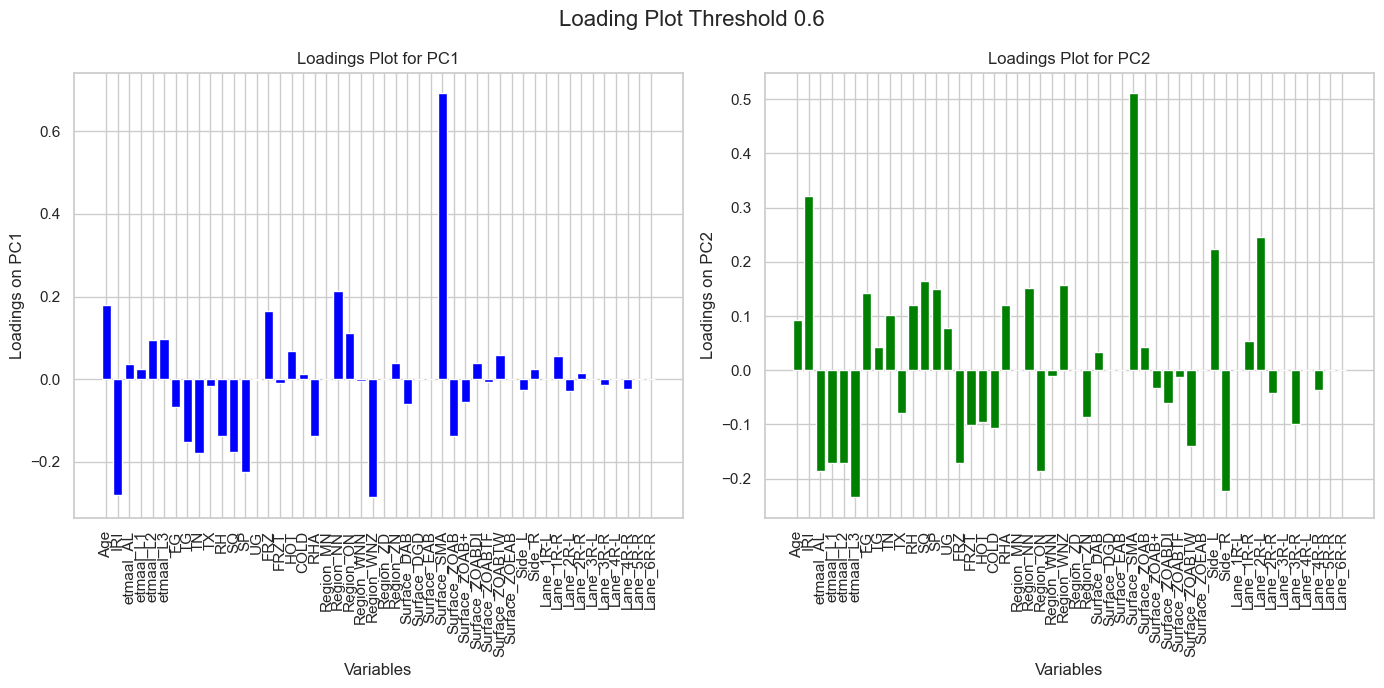

In [94]:
for i in frange(0.0, 1, 0.2):
    y_train_aux = y_train[y_train >= i]
    y_test_aux = y_test[y_test >= i]
    X_train_aux = X_train_scaled[y_train >= i].copy()
    X_test_aux = X_test_scaled[y_test >= i].copy()

    print(f'For IRI Increase greater than {i}:')

    print(len(y_train_aux))

    pca = PCA(n_components=4)
    pca_data = pca.fit_transform(X_train_aux)

    # Create a DataFrame with the PCA data
    pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])

    # Variance explained
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=X_train_aux.columns)

    plt.figure(figsize=(14, 7))
    # set a title for the plot
    plt.suptitle(f'Loading Plot Threshold {i}', fontsize=16)
    # Plot loadings for PC1
    plt.subplot(1, 2, 1)
    plt.bar(loadings.index, loadings['PC1'], color='blue')
    plt.xlabel('Variables')
    plt.ylabel('Loadings on PC1')
    plt.title('Loadings Plot for PC1')
    plt.xticks(rotation=90)

    # Plot loadings for PC2
    plt.subplot(1, 2, 2)
    plt.bar(loadings.index, loadings['PC2'], color='green')
    plt.xlabel('Variables')
    plt.ylabel('Loadings on PC2')
    plt.title('Loadings Plot for PC2')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

PCA Iteration

In [17]:
lr = LinearRegression()
corrs = dict()

for i in frange(0):
    y_train_aux = y_train[y_train >= i]
    y_test_aux = y_test[y_test >= i]
    X_train_aux = X_train_scaled[y_train >= i].copy()
    X_test_aux = X_test_scaled[y_test >= i].copy()

    aux_corrs = dict()

    for j in range(2, 20, 2):

        pca = PCA(n_components=j)
        X_train_pca_aux = pca.fit_transform(X_train_aux)
        X_test_pca_aux = pca.transform(X_test_aux)

        # split the data into train and test and convert them into tensors
        X_train_pca_tensor = torch.FloatTensor(X_train_pca_aux)
        X_test_pca_tensor = torch.FloatTensor(X_test_pca_aux)
        y_train_pca_tensor = torch.FloatTensor(y_train_aux)
        y_test_pca_tensor = torch.FloatTensor(y_test_aux)


        model = BNN(in_dim=X_train_pca_tensor.shape[1], out_dim=1, hid_dim=h, n_hid_layers=n, prior_scale=1)
                            # Set Pyro random seed
        pyro.set_rng_seed(42)
        nuts_kernel = NUTS(model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+
        # Define MCMC sampler and get posterior samples
        mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=33)
        # Run MCMC
        mcmc.run(X_train_pca_tensor, y_train_pca_tensor)

        predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
        preds_test = predictive(X_test_pca_tensor)
        preds_train = predictive(X_train_pca_tensor)
        bnn_test_pca = pd.DataFrame(preds_test['obs'].numpy().T)
        bnn_train_pca = pd.DataFrame(preds_train['obs'].numpy().T)

        test_corr = np.corrcoef(y_test_aux, y_test_lr)[0, 1]
        train_corr = np.corrcoef(y_train_aux, y_train_lr)[0, 1]

        aux_corrs[f'ncomp_{j}'] = (train_corr, test_corr)
        corrs[f'umbral_{i}'] = aux_corrs 


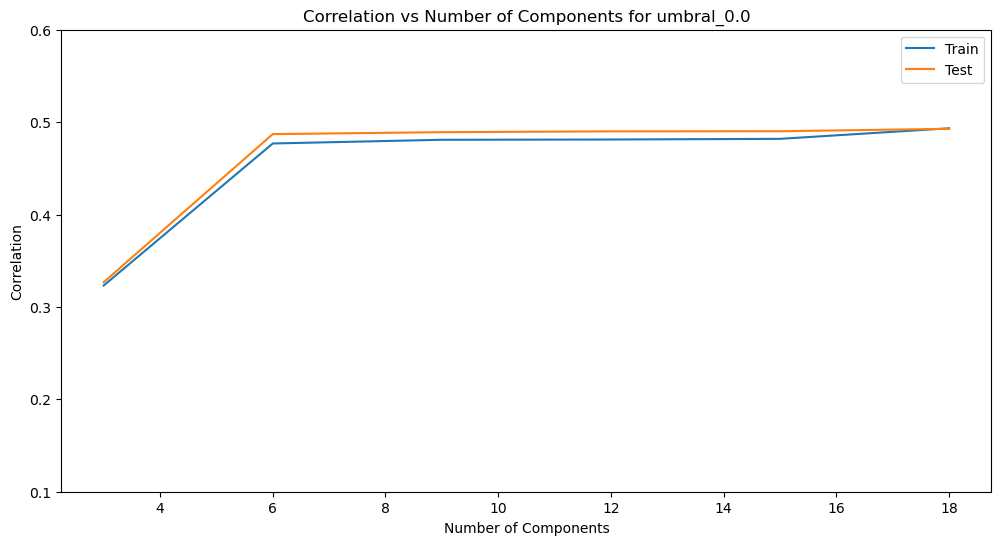

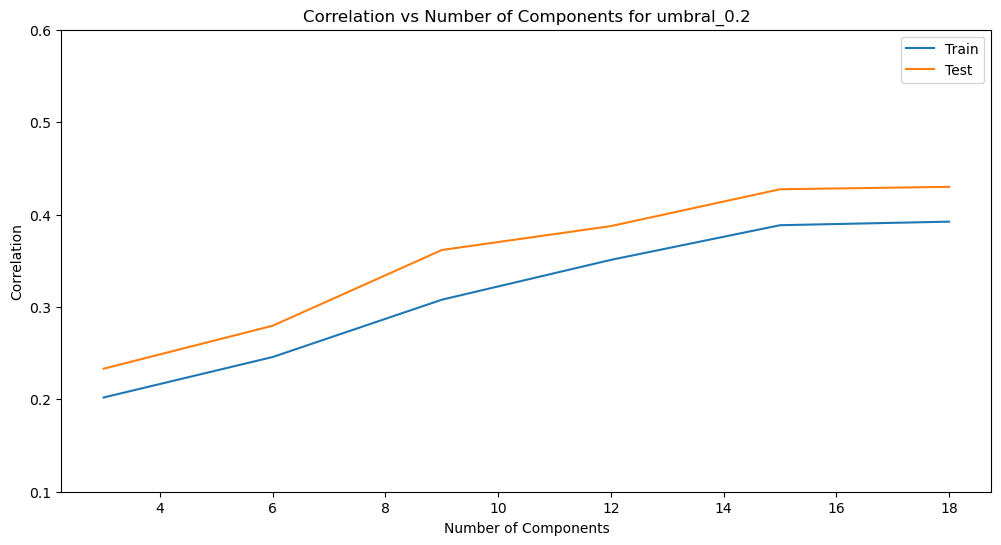

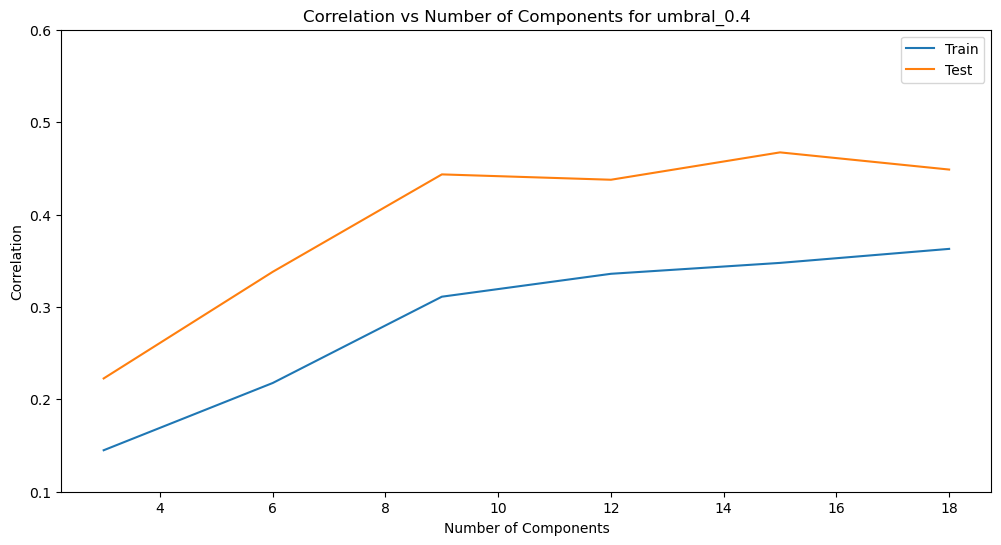

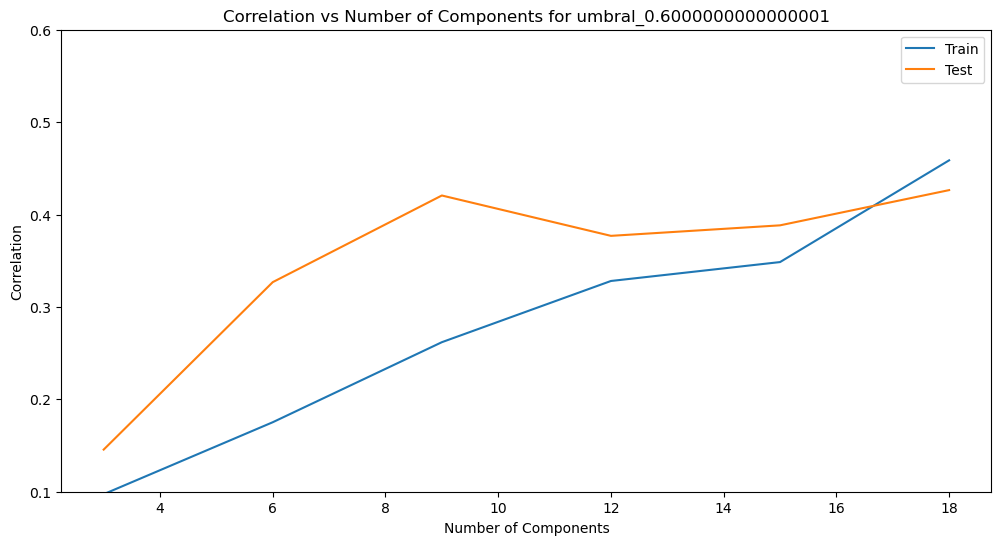

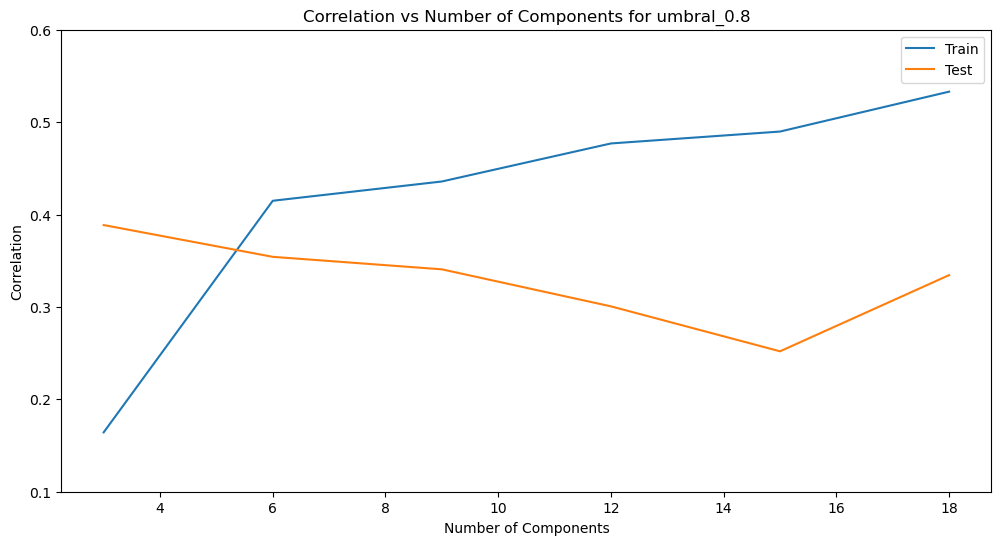

In [18]:
# create a line plot per umbral with the correlation values for different number of components

for key in corrs.keys():
    train_corr = [corrs[key][f'ncomp_{j}'][0] for j in frange(3, 21, 3)]
    test_corr = [corrs[key][f'ncomp_{j}'][1] for j in frange(3, 21, 3)]

    plt.figure(figsize=(12, 6))
    plt.plot(list(frange(3, 21, 3)), train_corr, label='Train')
    plt.plot(list(frange(3, 21, 3)), test_corr, label='Test')
    plt.xlabel('Number of Components')
    plt.ylabel('Correlation')
    plt.title(f'Correlation vs Number of Components for {key}')
    plt.ylim([0.1, 0.6])
    plt.legend()
    plt.show()


# BNN

I will use the same configuration as the NN model to train the BNN model.

In [8]:
class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=100, prior_scale=10):
        super().__init__()

        self.activation = nn.ReLU()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        # Apply activation function to hidden layer
        x = self.activation(self.layer1(x))
        # Mean of output layer
        mu = self.layer2(x).squeeze()
        # Return distribution over output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [11]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, n_hid_layers=4, prior_scale=1):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        # Removed reshaping step for multi-dimensional input
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu


### BNN Iterative Training


MCMC

In [ ]:
def calculate_parameters(n_in, n_out, n_hid_layers, hid_dim):
    n_params = (n_in * hid_dim) + ((n_hid_layers - 1) * (hid_dim * hid_dim)) + (hid_dim * n_out) + n_hid_layers * hid_dim + n_out
    return n_params

In [ ]:

for i in frange(0, 1, 0.2):
    y_train_aux = y_train[y_train >= i]
    y_test_aux = y_test[y_test >= i]
    X_train_aux = X_train_scaled[y_train >= i].copy()
    X_test_aux = X_test_scaled[y_test >= i].copy()

    for j in range(2, 12, 2):

        pca = PCA(n_components=j)
        X_train_pca_aux = pca.fit_transform(X_train_aux)
        X_test_pca_aux = pca.transform(X_test_aux)

        # split the data into train and test and convert them into tensors
        X_train_pca_tensor = torch.FloatTensor(X_train_pca_aux)
        X_test_pca_tensor = torch.FloatTensor(X_test_pca_aux)
        y_train_pca_tensor = torch.FloatTensor(y_train_aux)
        y_test_pca_tensor = torch.FloatTensor(y_test_aux)

        hid_dim_options = [2, 3, 4, 5, 10, 15, 20]
        n_hid_layers_options = [2, 3, 4, 5]

        for hid_dim in hid_dim_options:
            for n_hid_layers in n_hid_layers_options:

                n_params = calculate_parameters(X_train_pca_tensor.shape[1], 1, n_hid_layers, hid_dim)

                if X_train_pca_tensor.shape[0] >= 10 * n_params:

                    model = BNN(in_dim=X_train_pca_tensor.shape[1], out_dim=1, hid_dim=hid_dim, n_hid_layers=n_hid_layers, prior_scale=1)
                    # Set Pyro random seed
                    pyro.set_rng_seed(42)
                    nuts_kernel = NUTS(model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+
                    # Define MCMC sampler and get posterior samples
                    mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=33)
                    # Run MCMC
                    mcmc.run(X_train_pca_tensor, y_train_pca_tensor)
                    # get the poseterior samples
                    predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
                    preds_test = predictive(X_test_pca_tensor)
                    preds_train = predictive(X_train_pca_tensor)
                    # save the posterior samples to an excel file
                    df_test = pd.DataFrame(preds_test['obs'].numpy().T)
                    df_train = pd.DataFrame(preds_train['obs'].numpy().T)
                    df_test.to_excel(f'c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/Results/BNN_iterative/Test_MCMC_{i}_{j}_{hid_dim}_{n_hid_layers}.xlsx', index = False, header = False)
                    df_train.to_excel(f'c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/Results/BNN_iterative/Train_MCMC_{i}_{j}_{hid_dim}_{n_hid_layers}.xlsx', index = False, header = False)

    #--------------------------------------------------

## Analysis of the results

In [204]:
# read the predictions from the three models

#bnn_base = pd.read_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/Results/BNN_preds_base.xlsx', header=None)
bnn_test_selected = pd.read_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/Results/BNN_preds_test_selected_v2.xlsx', header=None)
bnn_train_selected = pd.read_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/Results/BNN_preds_train_selected_v2.xlsx', header=None)
bnn_test_pca = pd.read_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/Results/BNN_preds_test_pca_v2.xlsx', header=None)
bnn_train_pca = pd.read_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/Results/BNN_preds_train_pca_v2.xlsx', header=None)

The results of the scatter plot are similar to the ones obtained with the NN model. Again, the correlation between the real and predicted values is far better for the training set than for the test set.

### BNN Iterative Graphs

MCMC

In [7]:
results = pd.DataFrame(columns=['Threshold', 'PCA Components', 'Nodes per Layer', 'Layers', 'Train Correlation', 'Test Correlation'])
path = 'c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/Results/BNN_iterative/'

for i in frange(0.2, 1, 0.2):
    for j in range(3, 13, 3):
        hid_dim_options = [2, 3, 4]
        n_hid_layers_options = [2, 3, 4, 5]

        for hid_dim in hid_dim_options:
            for n_hid_layers in n_hid_layers_options:
                try:
    
                    bnn_train_pca = pd.read_excel(f'{path}Train_MCMC_{i}_{j}_{hid_dim}_{n_hid_layers}.xlsx', header=None)
                    bnn_test_pca = pd.read_excel(f'{path}Test_MCMC_{i}_{j}_{hid_dim}_{n_hid_layers}.xlsx', header=None)

                    y_train_aux = y_train[y_train >= i]
                    y_test_aux = y_test[y_test >= i]
                    
                    # append the results and the parameters to a data frame using pd.concat
                    results = pd.concat([results, pd.DataFrame([[i, j, hid_dim, n_hid_layers, np.corrcoef(y_train_aux, np.mean(bnn_train_pca.to_numpy(), axis=1))[0, 1], np.corrcoef(y_test_aux, np.mean(bnn_test_pca.to_numpy(), axis=1))[0, 1]]], columns=results.columns)], ignore_index=True)
                except:
                    pass

In [10]:
results

,Threshold,PCA Components,Nodes per Layer,Layers,Train Correlation,Test Correlation
0,0.2,3,2,2,0.329740,0.353564
1,0.2,3,2,3,0.314949,0.333402
2,0.2,3,2,4,0.338961,0.358834
3,0.2,3,2,5,0.361445,0.353669
4,0.2,3,3,2,0.405286,0.373489
...,...,...,...,...,...,...
80,0.4,12,3,2,0.550338,0.337568
81,0.4,12,3,3,0.696588,0.298008
82,0.4,12,3,4,0.650080,0.257809
83,0.4,12,4,2,0.574857,0.297368


In [12]:
# export the results to an excel file
results.to_excel('c:/Users/sergi/OneDrive/Escritorio/UPV/4_curso/TFG/Data/Results/BNN_Estudio_2.xlsx', index = False)

### TESTING

Selecting the best model

In [9]:
t = 0
p = 9
h = 25
n = 2

In [12]:
y_train_aux = y_train[y_train >= t]
y_test_aux = y_test[y_test >= t]
X_train_aux = X_train_scaled[y_train >= t].copy()
X_test_aux = X_test_scaled[y_test >= t].copy()

pca = PCA(n_components=p)
X_train_pca_aux = pca.fit_transform(X_train_aux)
X_test_pca_aux = pca.transform(X_test_aux)

# split the data into train and test and convert them into tensors
X_train_pca_tensor = torch.FloatTensor(X_train_pca_aux)
X_test_pca_tensor = torch.FloatTensor(X_test_pca_aux)
y_train_pca_tensor = torch.FloatTensor(y_train_aux)
y_test_pca_tensor = torch.FloatTensor(y_test_aux)


model = BNN(in_dim=X_train_pca_tensor.shape[1], out_dim=1, hid_dim=h, n_hid_layers=n, prior_scale=1)
                    # Set Pyro random seed
pyro.set_rng_seed(42)
nuts_kernel = NUTS(model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+
# Define MCMC sampler and get posterior samples
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=33)
# Run MCMC
mcmc.run(X_train_pca_tensor, y_train_pca_tensor)
# get the poseterior samples

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds_test = predictive(X_test_pca_tensor)
preds_train = predictive(X_train_pca_tensor)
bnn_test_pca = pd.DataFrame(preds_test['obs'].numpy().T)
bnn_train_pca = pd.DataFrame(preds_train['obs'].numpy().T)

Warmup:   0%|          | 0/133 [00:00, ?it/s]c:\Users\sergi\Anaconda3\Lib\site-packages\pyro\poutine\subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 133/133 [12:22,  5.58s/it, step size=1.72e-03, acc. prob=0.759]


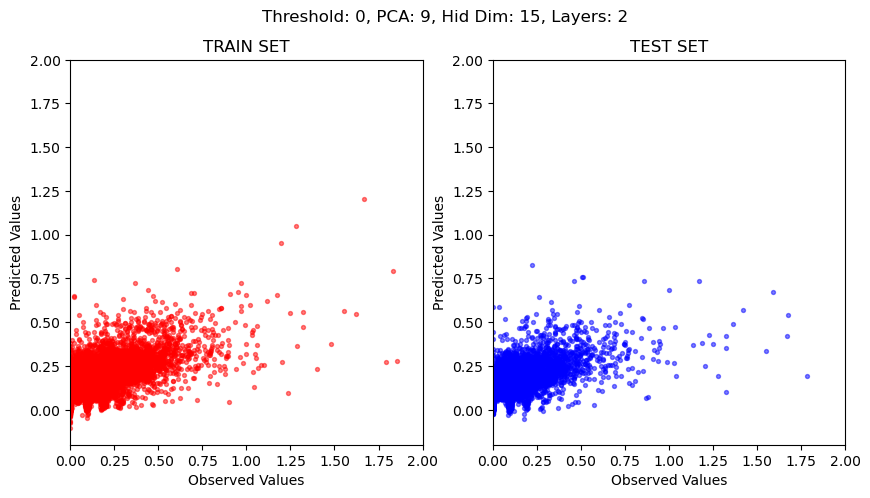

PCA Train Correlation: 0.6828812224744424
PCA Test Correlation: 0.6311522843563083
--------------------------------------------------



In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle(f'Threshold: {t}, PCA: {p}, Hid Dim: {h}, Layers: {n}')

ax[0].scatter(y_train_aux, np.mean(bnn_train_pca.to_numpy(), axis=1), alpha = 0.5, color='red', s = 8)
ax[0].set_xlim(0, 2)
ax[0].set_ylim(-0.2, 2)
ax[0].set_xlabel("Observed Values")
ax[0].set_ylabel("Predicted Values")
ax[0].set_title("TRAIN SET")
test_pca_corr = np.corrcoef(y_train_aux, np.mean(bnn_train_pca.to_numpy(), axis=1))[0, 1]

ax[1].scatter(y_test_aux, np.mean(bnn_test_pca.to_numpy(), axis=1), alpha = 0.5, color='blue', s = 8)
ax[1].set_xlim(0, 2)
ax[1].set_ylim(-0.2, 2)
ax[1].set_xlabel("Observed Values")
ax[1].set_ylabel("Predicted Values")
ax[1].set_title("TEST SET")
train_pca_corr = np.corrcoef(y_test_aux, np.mean(bnn_test_pca.to_numpy(), axis=1))[0, 1]

plt.show()
print(f'PCA Train Correlation: {test_pca_corr}')
print(f'PCA Test Correlation: {train_pca_corr}')
print('--------------------------------------------------', end='\n\n')

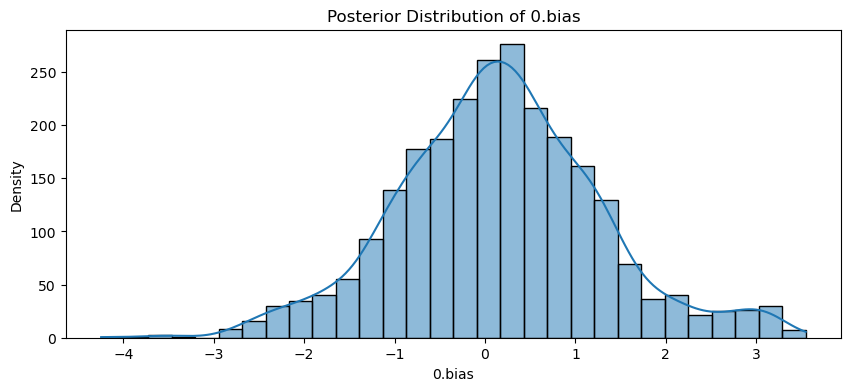

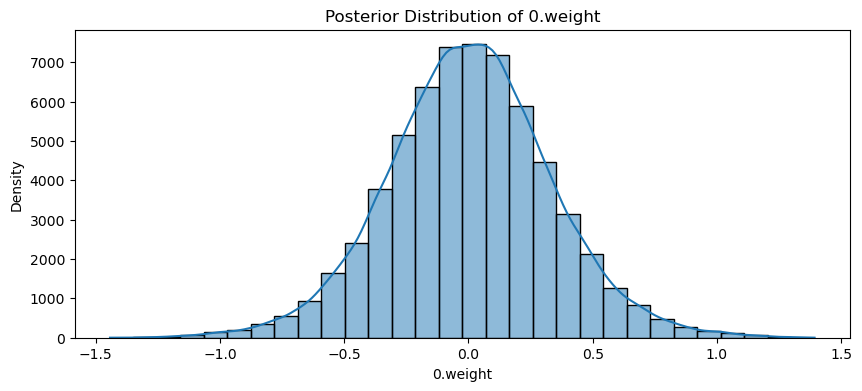

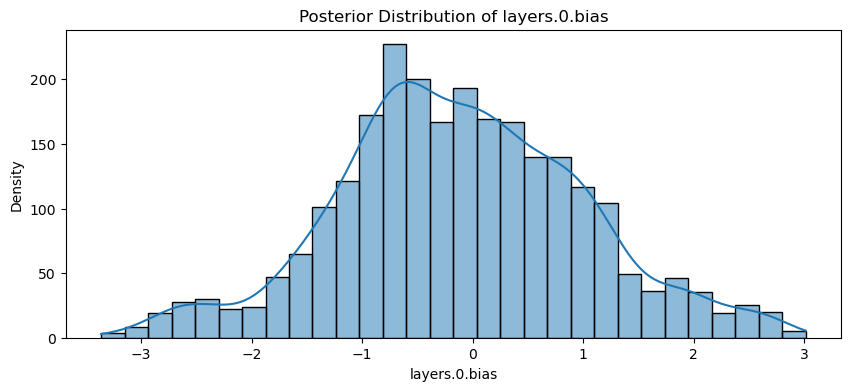

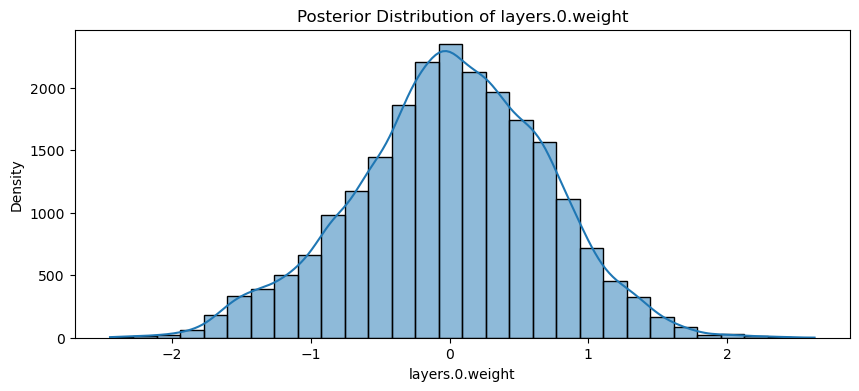

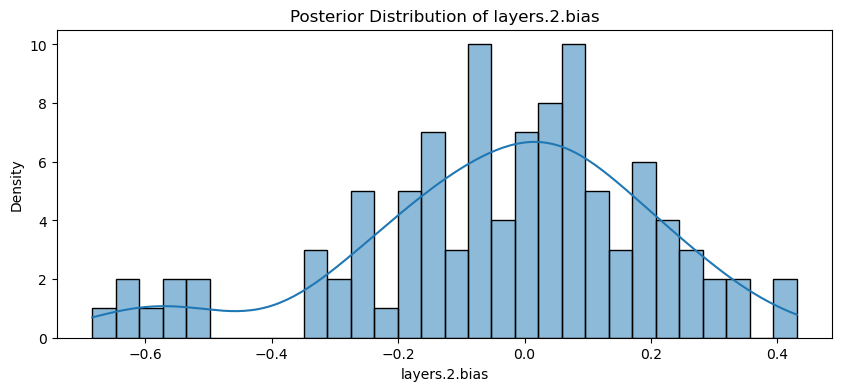

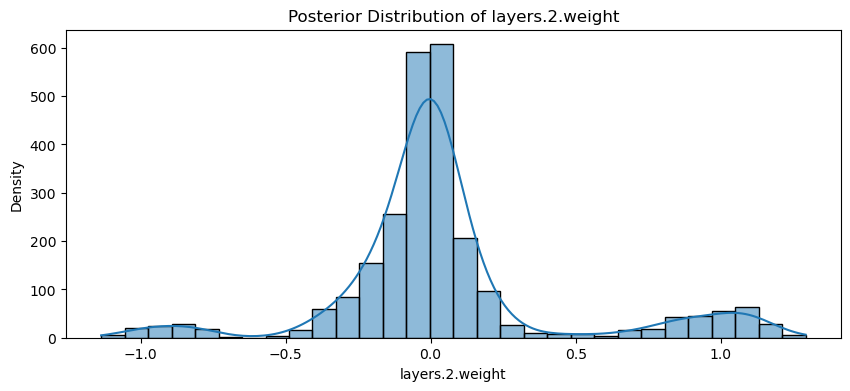

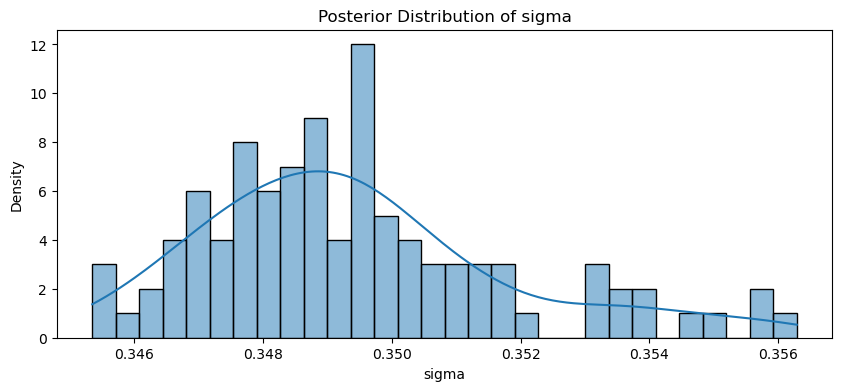

In [13]:
posterior_samples = mcmc.get_samples()

import matplotlib.pyplot as plt
import seaborn as sns

for param_name, param_samples in posterior_samples.items():
    plt.figure(figsize=(10, 4))
    sns.histplot(param_samples.numpy().flatten(), kde=True, bins=30)
    plt.title(f"Posterior Distribution of {param_name}")
    plt.xlabel(f"{param_name}")
    plt.ylabel("Density")
    plt.show()

In [ ]:
lr = LinearRegression()
corrs = dict()
i = 0

y_train_aux = y_train[y_train >= i]
y_test_aux = y_test[y_test >= i]
X_train_aux = X_train_scaled[y_train >= i].copy()
X_test_aux = X_test_scaled[y_test >= i].copy()

aux_corrs = dict()

for j in range(2, 20, 2):

    pca = PCA(n_components=j)
    X_train_pca_aux = pca.fit_transform(X_train_aux)
    X_test_pca_aux = pca.transform(X_test_aux)

    # split the data into train and test and convert them into tensors
    X_train_pca_tensor = torch.FloatTensor(X_train_pca_aux)
    X_test_pca_tensor = torch.FloatTensor(X_test_pca_aux)
    y_train_pca_tensor = torch.FloatTensor(y_train_aux)
    y_test_pca_tensor = torch.FloatTensor(y_test_aux)


    model = BNN(in_dim=X_train_pca_tensor.shape[1], out_dim=1, hid_dim=h, n_hid_layers=n, prior_scale=1)
                        # Set Pyro random seed
    pyro.set_rng_seed(42)
    nuts_kernel = NUTS(model, jit_compile=True)  # jit_compile=True is faster but requires PyTorch 1.6+
    # Define MCMC sampler and get posterior samples
    mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=33)
    # Run MCMC
    mcmc.run(X_train_pca_tensor, y_train_pca_tensor)

    predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
    preds_test = predictive(X_test_pca_tensor)
    preds_train = predictive(X_train_pca_tensor)
    bnn_test_pca = pd.DataFrame(preds_test['obs'].numpy().T)
    bnn_train_pca = pd.DataFrame(preds_train['obs'].numpy().T)

    test_corr = np.corrcoef(y_test_aux, np.mean(bnn_test_pca.to_numpy(), axis=1))[0, 1]
    train_corr = np.corrcoef(y_train_aux, np.mean(bnn_train_pca.to_numpy(), axis=1))[0, 1]

    aux_corrs[f'ncomp_{j}'] = (train_corr, test_corr)
    corrs[f'umbral_{i}'] = aux_corrs 


Warmup:   0%|          | 0/133 [00:00, ?it/s]c:\Users\sergi\Anaconda3\Lib\site-packages\pyro\poutine\subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Warmup:   0%|          | 0/133 [00:00, ?it/s]c:\Users\sergi\Anaconda3\Lib\site-packages\pyro\poutine\subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Warmup:   0%|          | 0/133 [00:00, ?

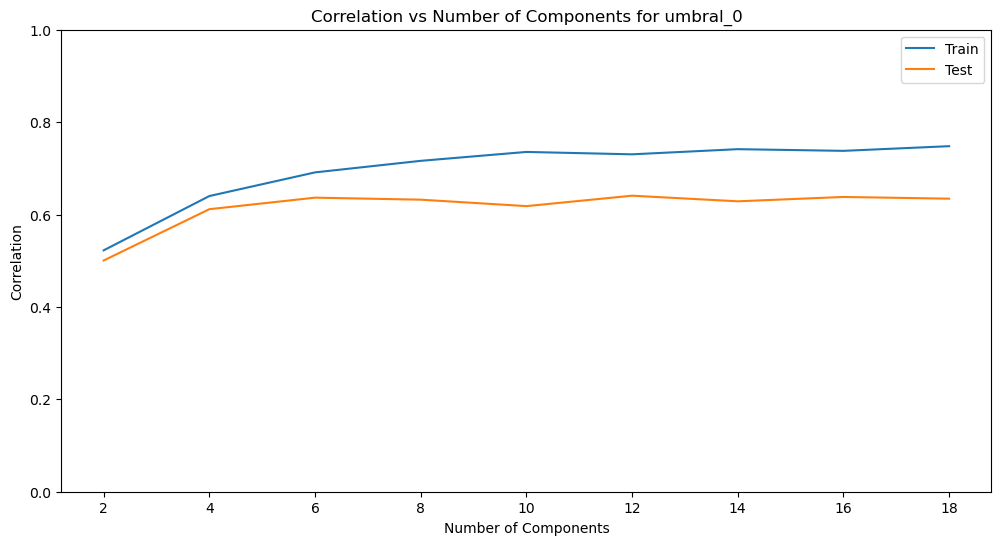

In [ ]:
# create a line plot per umbral with the correlation values for different number of components

for key in corrs.keys():
    train_corr = [corrs[key][f'ncomp_{j}'][0] for j in frange(2, 20, 2)]
    test_corr = [corrs[key][f'ncomp_{j}'][1] for j in frange(2, 20, 2)]

    plt.figure(figsize=(12, 6))
    plt.plot(list(frange(2, 20, 2)), train_corr, label='Train')
    plt.plot(list(frange(2, 20, 2)), test_corr, label='Test')
    plt.xlabel('Number of Components')
    plt.ylabel('Correlation')
    plt.title(f'Correlation vs Number of Components for {key}')
    plt.ylim([0, 1])
    plt.legend()
    plt.show()


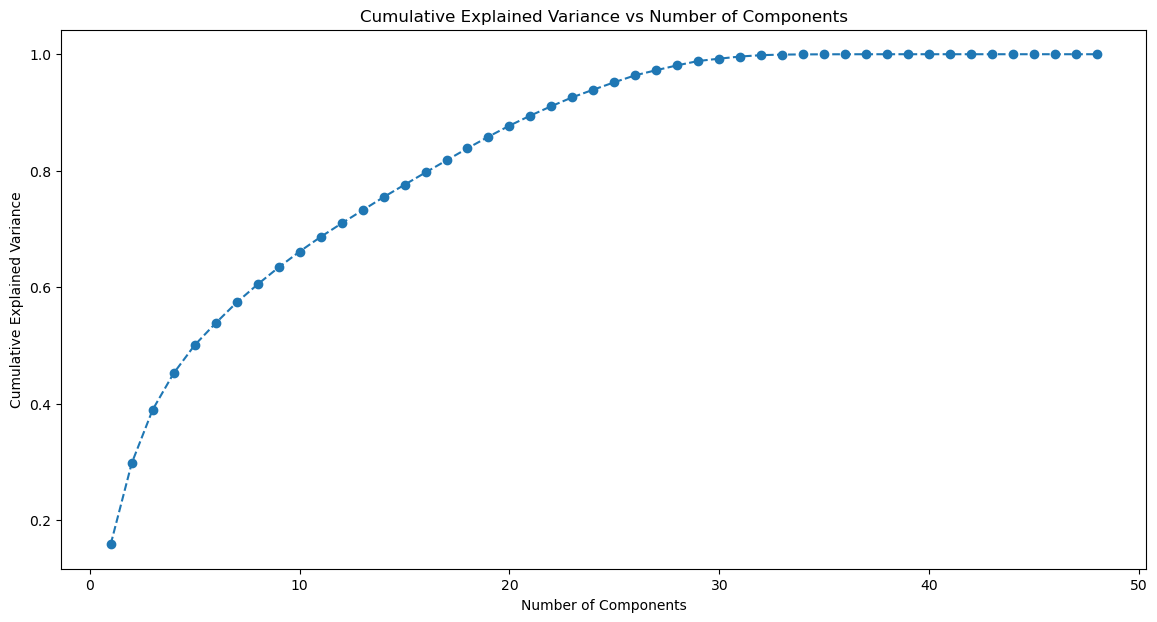

In [ ]:
# create a scree plot to see the accumulated variance explained by the components with my data.

y_train_aux = y_train[y_train >= t]
y_test_aux = y_test[y_test >= t]
X_train_aux = X_train_scaled[y_train >= t].copy()
X_test_aux = X_test_scaled[y_test >= t].copy()

pca = PCA()
X_train_pca_aux = pca.fit_transform(X_train_aux)
X_test_pca_aux = pca.transform(X_test_aux)

# Variance explained
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(14, 7))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.show()


